In [ ]:
!pip install tensorflow

In [ ]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, InputLayer
import matplotlib.pyplot as plt

In [ ]:
# Montar Google Drive (asumiendo que los datos están allí)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargar los datos
file_path = '/content/drive/MyDrive/DIPLOMADO EPM/Datos/BD_maestro.csv'
datos_Maestro = pd.read_csv(file_path)
datos_Maestro['fecha'] = pd.to_datetime(datos_Maestro['fecha'])
datos_Maestro.set_index('fecha', inplace=True)

In [ ]:
# Preparación de datos
features = datos_Maestro.drop(['ENSA', 'dummy'], axis=1)  # Excluir columnas no necesarias
labels = datos_Maestro['ENSA']

In [ ]:
# Escalar las características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)

In [ ]:
datos_Maestro.describe()

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA,dummy
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.0
mean,-0.042262,41.325214,0.056429,55.482143,0.085714,71.732143,3.432738,806.142857,283.601190,0.0
std,0.903917,15.107150,0.073764,13.913906,0.087003,22.023252,1.273004,123.033382,38.216393,0.0
min,-1.700000,25.066000,-0.180000,29.440000,-0.180000,17.000000,1.600000,529.000000,195.000000,0.0
25%,-0.700000,32.745000,0.050000,45.600000,0.070000,52.000000,2.600000,706.750000,254.750000,0.0
50%,-0.200000,37.277000,0.060000,55.964000,0.090000,72.000000,3.000000,827.500000,289.000000,0.0
75%,0.500000,41.799000,0.100000,64.929000,0.140000,89.750000,4.100000,894.000000,312.000000,0.0
max,2.600000,78.591000,0.160000,76.523000,0.180000,115.000000,8.800000,1067.000000,361.000000,0.0


In [ ]:
# Calcular la matriz de correlación
correlation_matrix = datos_Maestro.corr()

In [ ]:
# Considerar solo las correlaciones con respecto a 'ENSA'
correlation_with_ENSA = correlation_matrix['ENSA'].sort_values(ascending=False)

In [ ]:
# Seleccionar características con una correlación significativa

selected_features = correlation_with_ENSA[abs(correlation_with_ENSA) > 0.8].index.tolist()
selected_features.remove('ENSA')  # Asegurarse de no incluir la variable objetivo

In [ ]:
# Revisar las características seleccionadas
print("Características seleccionadas basadas en correlación:", selected_features)

Características seleccionadas basadas en correlación: ['Panama', 'PIB__corriente']


In [ ]:
# Preparar datos con las características seleccionadas
features_selected = datos_Maestro[selected_features]

In [ ]:
# Escalar las características seleccionadas
scaler = StandardScaler()
features_selected_scaled = scaler.fit_transform(features_selected)
features_selected_scaled_df = pd.DataFrame(features_selected_scaled, columns=selected_features)

In [ ]:
# Función para crear secuencias temporales
def create_sequences(features, labels, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features.iloc[i:(i + window_size)].values)
        y.append(labels.iloc[i + window_size])
    return np.array(X), np.array(y)

In [ ]:
# Crear secuencias
window_size = 6
X, y = create_sequences(features_selected_scaled_df, datos_Maestro['ENSA'], window_size=12)

In [ ]:
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Definir la arquitectura del modelo
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(50, activation='relu', return_sequences=True),
    GRU(50, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1)
])

In [ ]:
# Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
4/4 [==============================] - 6s 181ms/step - loss: 84556.3125 - val_loss: 84622.5469
Epoch 2/30
4/4 [==============================] - 0s 25ms/step - loss: 84480.6562 - val_loss: 84539.0156
Epoch 3/30
4/4 [==============================] - 0s 27ms/step - loss: 84387.9688 - val_loss: 84430.7031
Epoch 4/30
4/4 [==============================] - 0s 30ms/step - loss: 84264.6328 - val_loss: 84282.1953
Epoch 5/30
4/4 [==============================] - 0s 27ms/step - loss: 84090.2812 - val_loss: 84063.5625
Epoch 6/30
4/4 [==============================] - 0s 32ms/step - loss: 83830.7422 - val_loss: 83709.1953
Epoch 7/30
4/4 [==============================] - 0s 35ms/step - loss: 83371.5938 - val_loss: 83055.4844
Epoch 8/30
4/4 [==============================] - 0s 26ms/step - loss: 82448.2578 - val_loss: 81563.6250
Epoch 9/30
4/4 [==============================] - 0s 34ms/step - loss: 80129.3594 - val_loss: 76909.1406
Epoch 10/30
4/4 [==============================] - 0s 

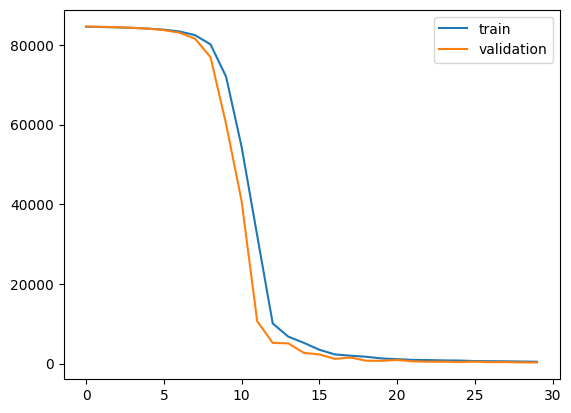

In [ ]:
# Graficar la historia de entrenamiento
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Preparar los datos para la predicción futura
if len(X_val) >= 6:
    # Tomar los últimos 12 registros de X_val
    last_window = X_val[-6:]  # Asegúrate de que estás tomando los últimos 12 timesteps

    # Verificación antes de expand_dims para asegurar la correcta manipulación de los datos
    print("Verificación de forma de last_window antes de expand_dims:", last_window.shape)

    # last_window ya debería tener la forma (12, 8) y sólo necesitas ajustarlo para que sea un batch
    if last_window.shape == (12, 8):
        last_window = np.expand_dims(last_window, axis=0)
        print("Forma de last_window después de expand_dims:", last_window.shape)

        # Realizar la predicción con el modelo
        predictions = model.predict(last_window)
        print("Predicciones:", predictions)
    else:
        print("La forma de last_window no es correcta, revisa la preparación de los datos.")
else:
    print("No hay suficientes datos en X_val para crear 'last_window' para predicciones")



Verificación de forma de last_window antes de expand_dims: (6, 12, 2)
La forma de last_window no es correcta, revisa la preparación de los datos.


In [ ]:
# Generar fechas futuras
last_known_date = datos_Maestro.index.max()
future_dates = pd.date_range(start=last_known_date + pd.DateOffset(months=1), periods=6, freq='MS')

# generar predicciones
predictions = model.predict(last_window)

1/1 [==============================] - 0s 479ms/step


In [ ]:
# Asegúrate de que las predicciones tienen la forma correcta
predictions = predictions.flatten()  # Aplanar el array si es necesario

# Crear un DataFrame para las predicciones
predicted_data = pd.DataFrame({
    'fecha': future_dates,
    'ENSA_pred': predictions
})

# Establecer 'fecha' como índice si prefieres trabajar con índices de fecha
predicted_data.set_index('fecha', inplace=True)


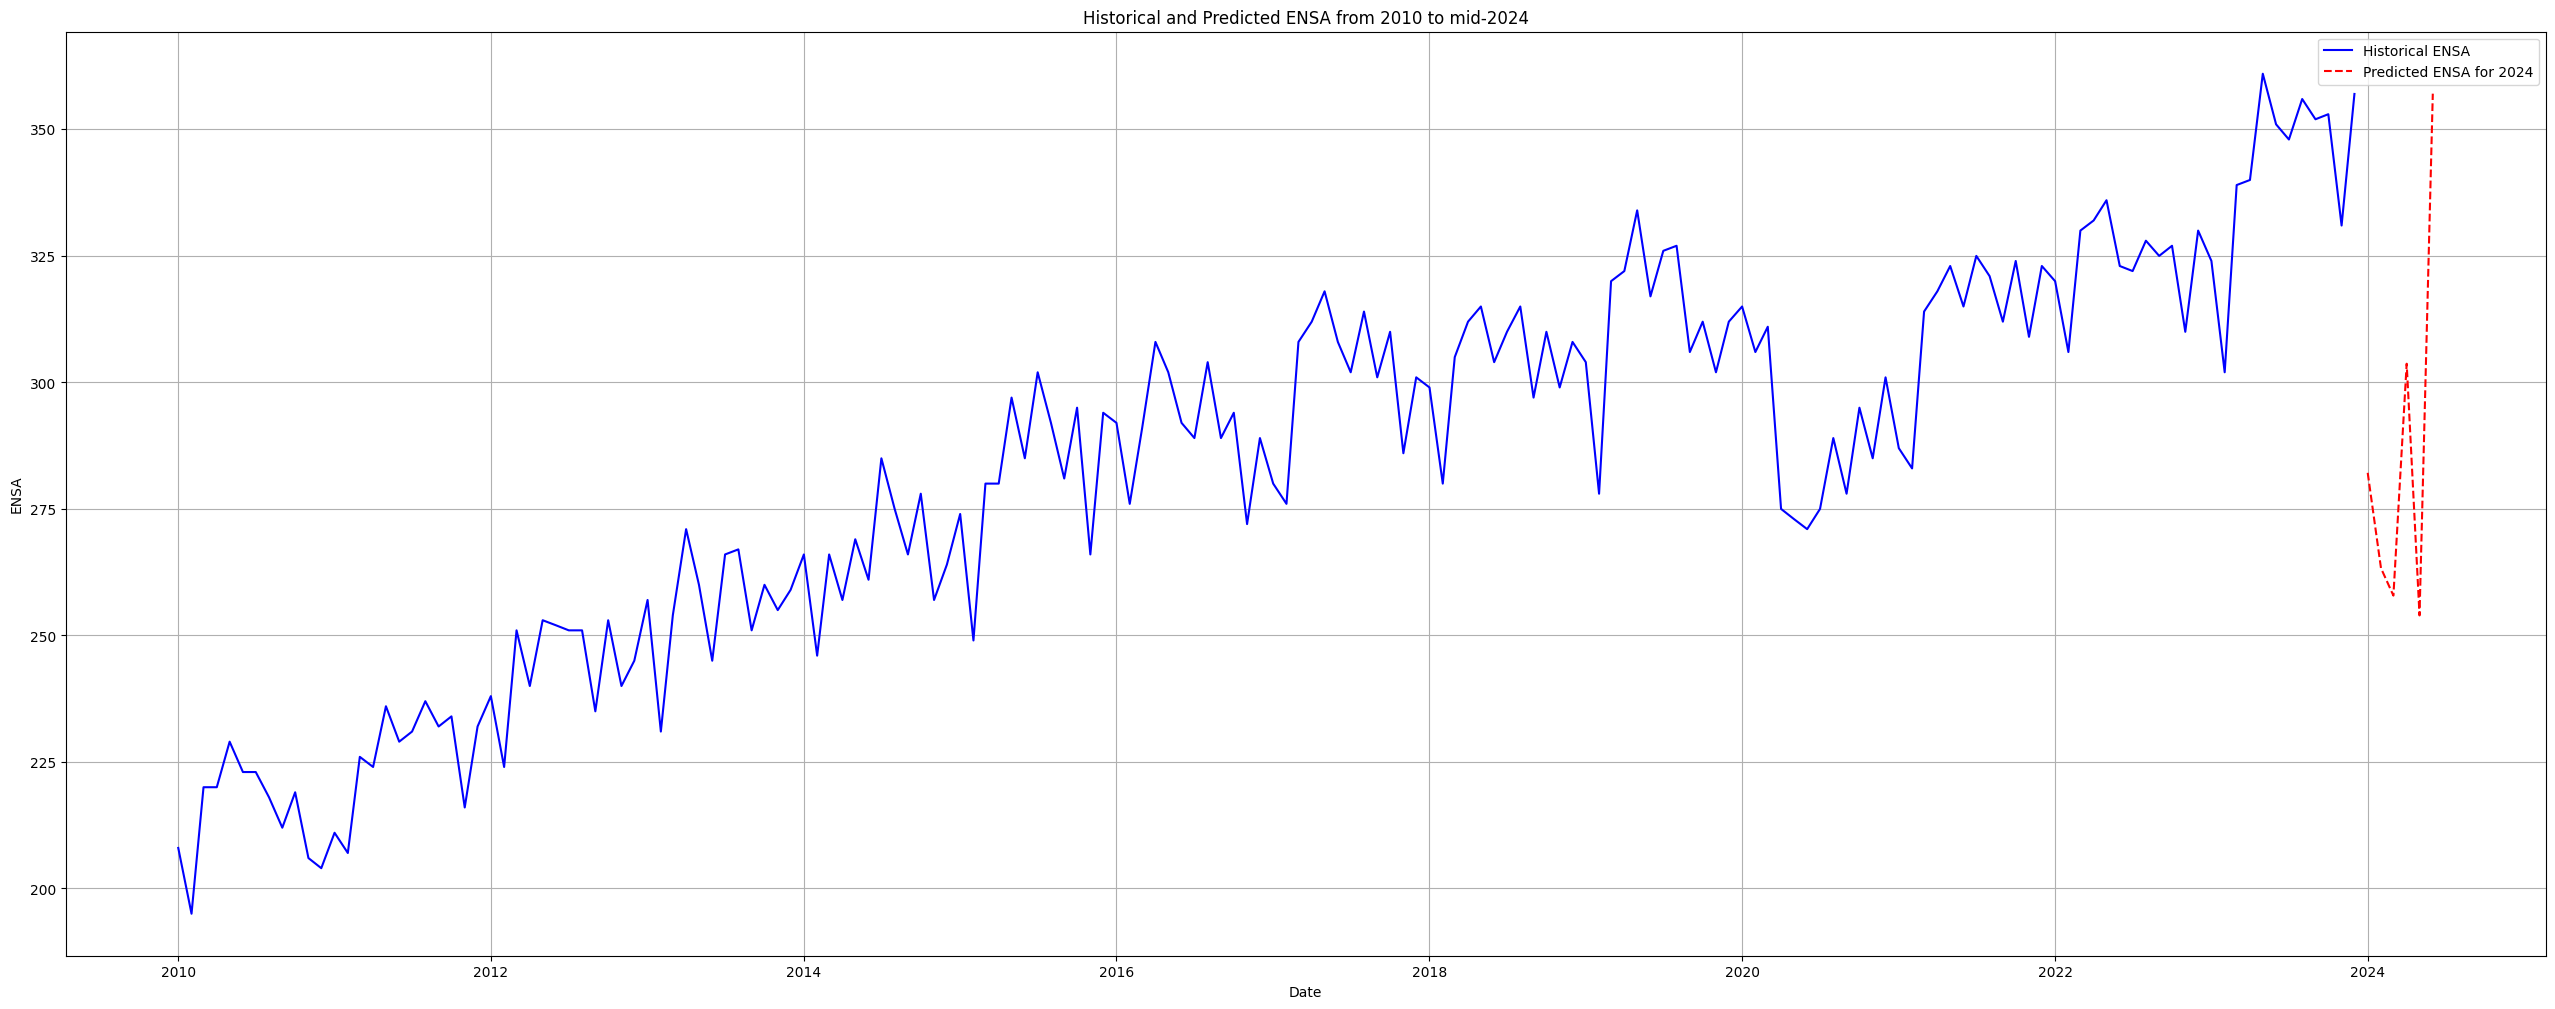

In [ ]:
# Graficar los resultados
plt.figure(figsize=(32, 12))
plt.plot(datos_Maestro.index, datos_Maestro['ENSA'], label='Historical ENSA', color='blue')
plt.plot(predicted_data.index, predicted_data['ENSA_pred'], label='Predicted ENSA for 2024', color='red', linestyle='--')
plt.title('Historical and Predicted ENSA from 2010 to mid-2024')
plt.xlabel('Date')
plt.ylabel('ENSA')
plt.legend()
plt.grid(True)
plt.show()